# A Step-by-Step Guide to the Tensor Flow Equation (TFE) Method

*By Dr S. J. Thomson (steven.thomson@fu-berlin.de)*  
*steventhomson.co.uk / @PhysicsSteve*  
*https://orcid.org/0000-0001-9065-9842*

The Tensor Flow Equation (TFE) method was first proposed in arXiv:2110.02906 by Marco Schiró and I as a way to take the method of continuous unitary transforms (also known as 'flow equations') and turn it into a robust numerical tool that did not require the algebraic complexity of previous analytical approaches. This was based on [our previous work](https://scholar.google.fr/citations?user=2UbaSwIAAAAJ&hl=en) using flow equation techniques which, while powerful, were extremely complicated to work with, and was inspired by my time working in the group of Laurent Sanchez-Palencia where I learned a lot about tensor network methods and realised I could use a similar approach to turn flow equations into a powerful numerical tool.

This Jupyter notebook was written in 2022 as part of a project taking place at the Dahlem Centre for Complex Quantum Systems, Freie Universität Berlin, together with C. Bertoni, J. Eisert, A. Kshetrimayum and A. Nietner (https://arxiv.org/abs/2208.14432), and the flow equation code has been used in other recent work (https://arxiv.org/abs/2208.11731). This project has received funding from the European Union’s Horizon 2020 research and innovation programme under the Marie Skłodowska-Curie grant agreement No.101031489 (Ergodicity Breaking in Quantum Matter). Please see my published works for a full description of the method and a comprehensive reference list to other works which have proposed, developed and used flow equation techniques, and without which this work would not exist.

### The Method

(The below is based on arXiv:2110.02906 by S. J. Thomson and M. Schiró.)


The core of the method is the idea of using a series of infinitesimal unitary transformations to diagonalise a particular system of interest. This is spiritually similar to the well-known Schrieffer-Wolff transform, where a Hamiltonian may be diagonalized to leading order by careful choice of a suitable unitary transformation:

$$
\tilde{\mathcal{H}} = \textrm{e}^{S} \mathcal{H} \textrm{e}^{-S} = \mathcal{H} - [\mathcal{H},S] + ...,
$$

and choosing the generator $S$ such that $[\mathcal{H},S]$ is equal to the off-diagonal terms of the Hamiltonian which we wish to remove. In general, this procedure will also generate new higher-order terms which must then be removed by further transforms, or treated in some other perturbative manner. Here, rather than making a single 'large' unitary transform, we instead make a series of infinitesimal transforms, each of which can be made arbitrarily accurate:

$$
\mathcal{H}(l + d l) = \textrm{e}^{\eta(l) d l} \mathcal{H}(l) \textrm{e}^{-\eta(l) d l}= \mathcal{H}(l) + d l \phantom{.} [\eta(l),\mathcal{H}(l)] .
$$

where $l$ is a fictitious 'flow time' which parameterises the transform, and $\eta(l)$ is some scale-dependent anti-Hermitian generator chosen to diagonalize the specific problem of interest in the $l \to \infty$ limit. In the spirit of renormalization group techniques, the transformation of the Hamiltonian can be written in terms of a single so-called flow equation:

$$
\frac{d \mathcal{H}(l)}{d l} = [\eta(l),\mathcal{H}(l)] 
$$

such that the eventual 'fixed point' of the flow is a diagonal Hamiltonian, with $ [\eta(l\to \infty),\mathcal{H}(l\to \infty)] =0$. The properties of the final fixed-point Hamiltonian are controlled by the generator $\eta(l)$, which we can freely choose to be any anti-Hermitian operator such that the overall transform is unitary.
The choice of generator is far from unique and various options exist in the literature which result in a diagonal fixed-point Hamiltonian, however a common choice is the so-called 'Wegner generator':

$$
\eta(l) = \left[ \mathcal{H}_0(l), V(l) \right]
$$

where $\mathcal{H}_0$ represents the diagonal terms in the Hamiltonian and $V = \mathcal{H}-\mathcal{H}_0$ contains the off-diagonal terms which we want to vanish in the $l \to \infty$ limit. 
The Wegner generator is suitable for most problems as it a robust choice that can be stably numerically integrated, although it has the significant disadvantage for sparse models (i.e. those with nearest-neighbour couplings only) that it does not preserve the sparsity of the initial Hamiltonian, and in the early stages of the flow it typically generates long-range off-diagonal couplings which must be kept track of until they later decay to zero. Other choices of generator exist which do preserve the sparsity of nearest-neighbour models, however they are typically much less numerically stable, and so we do not consider them here. 

## A Warmup: Non-interacting Fermions

Let me first start by setting some environment variables and importing some of the necessary packages. This is just standard stuff that I do at the start of almost every script, so don't worry too much about this part. (I also set up `matplotlib` to use LaTeX fonts for plotting figures.)

In [55]:
from psutil import cpu_count
import os
os.environ['OMP_NUM_THREADS']= str(int(cpu_count(logical=False))) # Set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']= str(int(cpu_count(logical=False))) # Set number of MKL threads to run in parallel
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"                         # Necessary on some versions of OS X
os.environ['KMP_WARNINGS'] = 'off'                                # Silence non-critical warning
import numpy as np 
from datetime import datetime
import h5py

import matplotlib.pyplot as plt                                   # Part to change plotting system
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,6)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})
plt.rc('text', usetex=True)
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams.update(mpl.rcParamsDefault)

I'll start by defining some of the system parameters we'll use.

In [56]:
# Set Hamiltonian parameters
L = 50                                                            # Linear system size
dim = 1                                                          # Spatial dimension
n = L**dim                                                       # Total number of sites
W = 5.                                                           # Disorder strength
J = 1.                                                           # Hopping

We'll use these to construct the non-interacting Hamiltonian as a matrix, and compute its exact eigenvalues using NumPy's built-in function. The Hamiltonian we'll use here is the following 1D fermionic model with nearest-neighbour hopping and a varying on-site potential (which we'll choose here to be randomly drawn from a distribution $[-W,W]$):

$$
H = \sum_i h_i n_i + J \sum_{i} (c^{\dagger}_i c_{i+1} + H.c.)
$$

In [15]:
H0 = np.diag(np.random.uniform(-W,W,n))
V = np.diag(J*np.ones(n-1),1)+np.diag(J*np.ones(n-1),-1)
H = H0 + V
print(H)
eig,_ = np.linalg.eigh(H)
print('Exact solution: ', eig)

[[-0.21299055  1.          0.         ...  0.          0.
   0.        ]
 [ 1.          4.28922737  1.         ...  0.          0.
   0.        ]
 [ 0.          1.         -0.25291244 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -4.3568223   1.
   0.        ]
 [ 0.          0.          0.         ...  1.          3.14705881
   1.        ]
 [ 0.          0.          0.         ...  0.          1.
  -4.97464404]]
Exact solution:  [-5.18241317 -5.12382419 -4.69976522 -4.59222429 -4.40898715 -4.14961703
 -4.13753697 -3.9016585  -3.30342932 -2.81389513 -2.31095186 -2.12018764
 -1.98754993 -1.64944963 -1.57514168 -1.55429995 -1.34479426 -1.05730121
 -0.95595786 -0.86897974 -0.70866664 -0.48314813 -0.43682936  0.08821485
  0.13163985  0.34882061  0.76249885  0.77927145  0.96767415  1.19051962
  1.43810989  1.57275318  1.65235257  2.23359092  2.39991441  2.85222969
  2.87542808  2.95320378  3.10184801  3.38050699  3.43237559  3.54761212
  3.75470294  3.7607

### Define $\Gamma_{jk} = \langle f_{j}^{\dagger} f_k \rangle$ and initialise to $|0,1,0,1,0,1, \ldots, 0,1\rangle$

In [57]:
a = np.zeros((1,int(n/2)))
b = np.ones((1,int(n/2)))

gamma_mat = np.concatenate((a,b),axis=0)
gamma_mat = gamma_mat.flatten('F')
gamma_mat = np.diag(gamma_mat)
print(gamma_mat)
h = np.diag(J*np.ones(n-1),1)+np.diag(J*np.ones(n-1),-1)
h[0][n-1] = 1
h[n-1][0] = 1
print(h)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 1. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]]


### Evolve $\Gamma$ using $\partial_t \Gamma_t = i[h,\Gamma_t]$

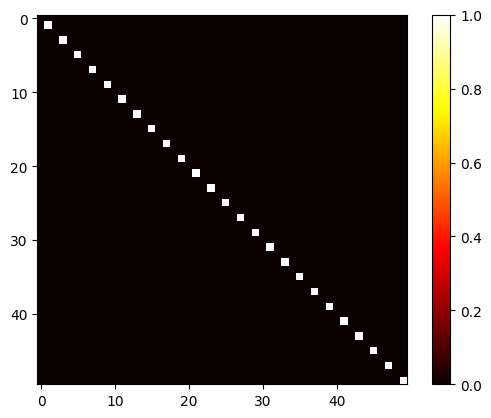

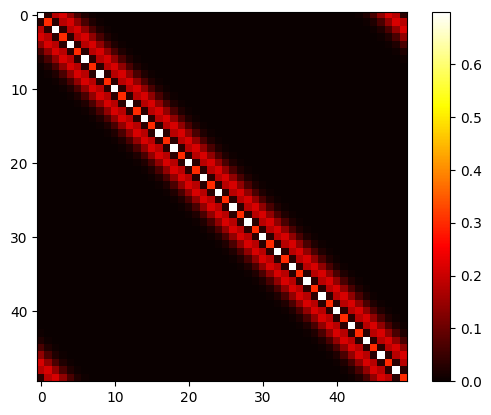

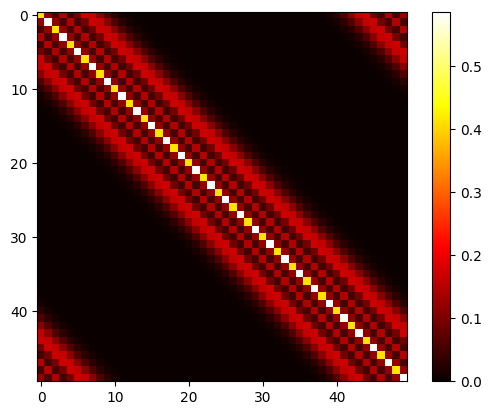

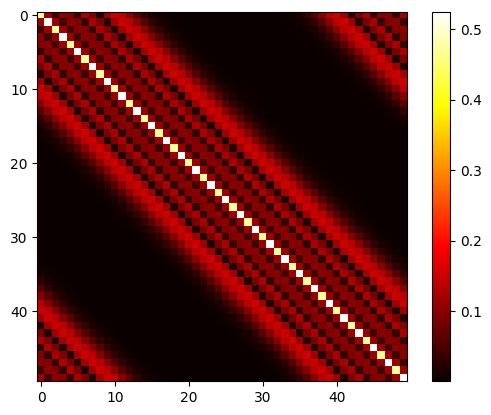

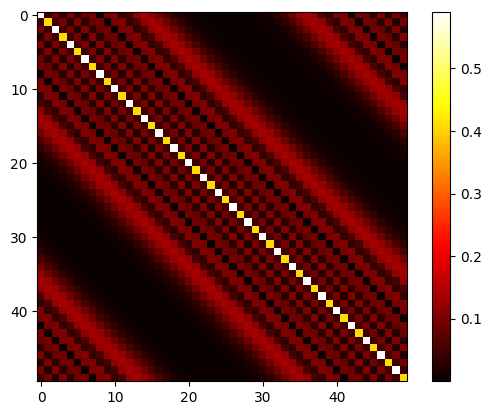

In [58]:
dl = 1e-3               # step size     
steps = 5000
for i in range(steps):   
    eta = 1j*(h@gamma_mat - gamma_mat@h)                                     
    gamma_mat = gamma_mat + dl*eta
    if i%1000 == 0:
        plt.imshow(abs(gamma_mat),cmap='hot',interpolation='nearest')
        plt.colorbar()
        plt.show()


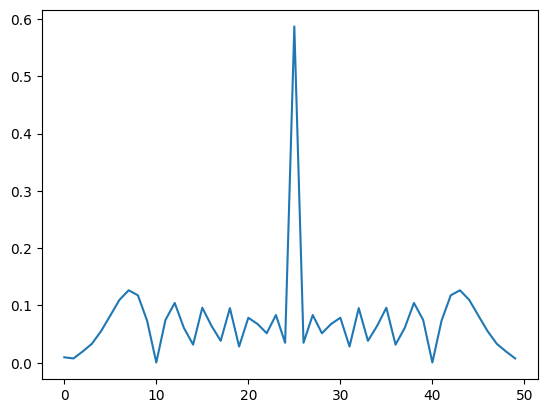

In [59]:
#x_pos = 25
positions = [25]
for x_pos in positions:
    vec_corr = np.abs(gamma_mat[:, x_pos])
    plt.plot(vec_corr)

Now that we've established the model we'll be working with, let's take a look at how flow equations can be used to solve it.

### A First Crude Attempt

In the below code, I'll implement a flow equation method in the simplest, most naive way. We will simply make an in-place update of the Hamiltonian at each flow time step $dl$, according to the rule:

$$
H(l + dl) \approx H(l) + dl[\eta(l),H(l)]
$$

We'll start by defining the step size $dl$ (which should be small), and a cutoff for the off-diagonal elements below which we will consider the Hamiltonian to be effectively diagonal. We'll then update the Hamiltonian according to the above rule until the convergence criterion is met, using a `while` loop. At the end of this small block of code, we will take the diagonal elements of the transformed Hamiltonian and compare them to the exact eigenvalues obtained above.

In [5]:
dl = 1e-3                                                           # Step size
J0 = np.max(np.abs(V))                                              # Largest off-diagonal element
cutoff = 1e-3                                                       # Cutoff for off-diagonal elements
step_count = 0 

while J0 > cutoff:                                                  # Loop until off-diagonal elements decay
    H0 = np.diag(np.diag(H))                                        # Extract diagonal part of Hamiltonian
    V = H-H0                                                        # Extract off-diagonal part of Hamiltonian
    J0 = np.max(np.abs(V))                                          # Compute max off-diagonal element
    eta = H0@V - V@H0                                               # Compute generator eta=[H0,V]
    dH = eta@H - H@eta                                              # Compute dH/dl = [eta/H]           
    H += dl*dH                                                      # Advance H(l) -> H(l+dl)
    step_count += 1                                                 # Increment step count
    
flow = np.sort(np.diag(np.round(H,8)))                              # Extract diagonal of final Hamiltonian

# Compute relative error
rel_err = np.mean([np.abs((flow[i]-eig[i])/eig[i]) for i in range(n)])

print('Steps taken = %s' %step_count)
print('l_max = %.2f' %(step_count*dl))
print('Flow eigenvalues:  ', flow)
print('Exact eigenvalues: ', eig)
print('Relative error = %.4f' %rel_err)

Steps taken = 204972
l_max = 204.97
Flow eigenvalues:   [-4.09509815 -3.91492884 -1.24288483  1.65535271  1.79907669  3.62823538]
Exact eigenvalues:  [-4.09092948 -3.91142067 -1.24218935  1.65377122  1.7959568   3.62456444]
Relative error = 0.0010


It works! As it's a random system, the accuracy and total number of steps taken will vary each time this is run, but in testing it typically takes $\sim 30000$ steps, with $dl = 10^{-3}$ and a final flow time $l_{max} \sim 30$ to diagonalise the Hamiltonian with a relative error $\varepsilon \sim 0.01$, i.e. a one percent error in the final eigenvalues.

This works, but can we do better?

### A More Sophisticated Version

The above code works well and gives us the right answer, but it's a bit simplistic. In particular, we're just repeatedly advancing the Hamiltonian by a fixed timestep $dl$, which has an error proportional to the step size (e.g. see https://en.wikipedia.org/wiki/Euler_method).

We can do a bit better by properly solving the differential equation $dH/dl$ using a more advanced method. In this case we'll make use of SciPy's `odeint` function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) and use an adaptive step-size 4th order Runge-Kutta algorithm (https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method) with an error $\sim dl^5$.

I'm also going to rewrite the matrix multiplication step to use NumPy's `einsum` function rather than the `A@B` notation used above, here enclosed in the function `comm(A,B)` - this does the same thing as the previous example, but gives a bit more control/transparency over what's going on. This will be important later when we look at interacting systems, where `einsum` is a convenient (if not particularly fast...!) way to specify the tensor contractions required using the Einstein summation notation.

In [6]:
from scipy.integrate import odeint

# Function to contract square matrices (matrix multiplication)
def comm(A,B):
    return np.einsum('ik,kj ->ij ',A,B) - np.einsum('ik,kj ->ij',B,A)

# Function to compute the RHS of the flow equation
def nonint_ode(H,l):
    n = int(np.sqrt(len(H)))
    H = H.reshape(n,n)
    H0 = np.diag(np.diag (H))
    V0 = H - H0
    eta = comm(H0,V0)
    sol = comm(eta,H)

    return sol.reshape(n**2)

I'll rebuild a new random Hamiltonian here, as the $H$ we looked at previously has already been diagonalised.

In [7]:
H0 = np.diag(np.random.uniform(-W,W,n))
V = np.diag(J*np.ones(n-1),1)+np.diag(J*np.ones(n-1),-1)
H = H0 + V
print(H)
eig,_ = np.linalg.eigh(H)
print('Exact solution: ', eig)

[[ 1.36522831  1.          0.          0.          0.          0.        ]
 [ 1.         -0.71484631  1.          0.          0.          0.        ]
 [ 0.          1.          0.96867732  1.          0.          0.        ]
 [ 0.          0.          1.         -2.63041451  1.          0.        ]
 [ 0.          0.          0.          1.          2.45451673  1.        ]
 [ 0.          0.          0.          0.          1.         -2.13750425]]
Exact solution:  [-3.12447161 -2.30069153 -1.40156655  1.26845857  2.00297312  2.86095527]


Now we can go ahead and solve the problem. 

There are a few small differences, the first being that SciPy requires a list of flow times from $l_{min}$ to $l_{max}$. I'll specify these as a logarithmically spaced grid of flow time values, anticipating our later finding that the Hamiltonian will change most rapidly at small values of flow time $l$, and much more slowly at large flow times, allowing us to gradually increase the step size as we go. If you're worried about the integration error, then don't panic - SciPy will insert additional interpolation steps as required to keep the error under control. (This can be manually fine-tuned but for this example we don't need to do anything so complicated.)

We can now compute the diagonal Hamiltonian and compare the eigenvalues to the exact solution.

In [22]:
# Generate list of flow time steps to store
# dl_list = np.linspace(0,10,100,endpoint = True)
dl_list = np.logspace(-3,1,100,endpoint = True)

# Run the solver
sol = odeint(nonint_ode,(H).reshape(n**2),dl_list)

# Extract the final eigenvalues
flow=np.sort(np.diag(sol[-1].reshape(n,n)))

# Compute relative error
rel_err = np.mean([np.abs((flow[i]-eig[i])/eig[i]) for i in range(n)])

print('Steps taken = %s' %len(sol))
print('Flow eigenvalues:  ', flow)
print('Exact eigenvalues: ', eig)
print('Relative error = %.4f' %rel_err)

Steps taken = 100
Flow eigenvalues:   [-4.38135145 -2.88614992 -2.32403679 -0.07609202  1.85076275  2.67772885]
Exact eigenvalues:  [-3.12447161 -2.30069153 -1.40156655  1.26845857  2.00297312  2.86095527]
Relative error = 0.4192


The results will vary each time this is run, but in general this produces a much more accurate result than the previous method by a few orders of magnitude.

(Note that `steps_taken` is a lot less here because it measures the length of `dl_list` and doesn't take into account the internal behaviour of `odeint`, which adds intermediate steps when necessary to improve accuracy.)

We can plot the flow of the Hamiltonian to get some idea of how it evolves under this transform. The solid lines with `o` markers represent the diagonal terms in the Hamiltonian (which as $l \to \infty$ should converge to the eigenvalues), while the dashed lines with `x` markers are the off-diagonal terms (and should all decay to zero by the end of the flow).

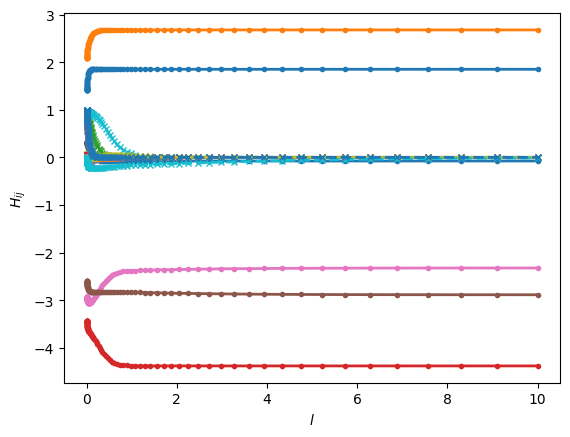

In [23]:
sol=sol.reshape (len(sol),n,n)
for i in range (n):
    # Plot the flow of the on - site terms as a solid line with circular markers
    plt.plot(dl_list,sol[:,i,i],linewidth =2, marker ='o',markersize =3)
    for j in range (i):
        # Plot the flow of the off - diagonal terms as a dashed line with cross markers
        plt.plot(dl_list,sol[:,i,j],'--',linewidth =2, marker ='x',markersize=5)
plt.xlabel(r'$l$')
plt.ylabel(r'$H_{ij}$')
plt.show()
plt.close()

For non-interacting systems, we can go even further and compute the eigenvectors, the full unitary that diagonalises the problem, and even the exact non-equilibrium dynamics, but I think by now you get the point. Let's move on to the interacting model.

## Interacting Systems

Now we add interactions, and it turns out that we can no longer obtain an exact solution. The Hamiltonian we'll work with is the following:

$$
H = \sum_i h_i :n_i: + J \sum_{i} (:c^{\dagger}_i c_{i+1}: + H.c.) + \Delta_{0}  \sum_{i} :n_i n_{i+1}:
$$

where the $:...:$ notation signifies normal-ordering. The end result of our diagonalization procedure will be a Hamiltonian of the form:

$$
\tilde{H} = \sum_i \tilde{h}_i \tilde{n}_i + \frac12 \sum_{ij} \tilde{\Delta}_{ij} \tilde{n}_i \tilde{n}_j + ...
$$

where the $...$ refers to neglected higher order terms, and the tilde means all quantities are given in the $l \to \infty$ basis. 

Before we get too far into the method, let's take a brief detour into normal-ordering and why I chose to write the Hamiltonian in this slightly weird way.

### Normal-ordering

(The below is based on arXiv:2110.02906 by S. J. Thomson and M. Schiró.)

In order to compute the commutators required for flow equation methods, we need to ensure a consistent order of fermionic operators in the Hamiltonian. In general swapping the order of two fermionic operators can result in the generation of new terms, e.g.:

$$
c^{\dagger}_i c_j c^{\dagger}_k c_q = c^{\dagger}_i (c^{\dagger}_k c_j + \delta_{jk}) c_q = c^{\dagger}_i c^{\dagger}_k c_j c_q + \delta_{jk} c^{\dagger}_i c_q
$$

Therefore if this term arose when evaluating $d H/ d l$, one could arrange the operators in the form $c^{\dagger}_i c_j c^{\dagger}_k c_q$ and conclude that this term renormalizes the quartic terms only, or one could rearrange the operators into the form $c^{\dagger}_i c^{\dagger}_k c_j c_q + \delta_{jk} c^{\dagger}_i c_q$ and conclude that this term renormalized both quartic and quadratic parts of the Hamiltonian. While not necessarily inconsistent, this arbitrariness complicates the computation of high-order commutators.
The key ingredient in avoiding this ambiguity is known as normal-ordering, which enforces a consistent ordering of the operators in each term. While this prescription is often thought of as simply subtracting the expectation value from an operator, the fundamental idea is rather more sophisticated. For fermions, it consists of expressing a fermionic anticommutation relation as:

$$
\{ c^{\dagger}_i, c_j \} =  G_{ij} + \tilde{G}_{ji}
$$

where we define the contractions used in normal-ordering as:

$$
G_{ij} = \langle c^{\dagger}_i c_j \rangle \\
\tilde{G}_{ji} = \langle c_j c^{\dagger}_i \rangle
$$

and the expectation values are computed in some reference state, which is typically the ground state of the corresponding non-interacting model, but can also be a more complex mixed state described by some density matrix.
To calculate the commutation relations of normal-ordered strings of operators, we use the following theorem:

$$
:O_1 (A): :O_2 (A'): = : \exp \left( \sum_{kl} G_{kl} \frac{\partial^2}{\partial A'_{l} \partial A_{k}} \right) O_{1} (A) O_{2}(A'):
$$

where $A$ and $A'$ are the set of labelled operators in the expression $O_1$ and $O_2$ which in our case are just strings of fermionic operators. Note that for fermions, the derivatives with respect to operators in $O_1$ must be performed first, and that the derivatives obey the following identity:

$$
\frac{\partial}{\partial A_l} A_k = \delta_{lk} - A_k \frac{\partial}{\partial A_l}
$$


i.e. there are some minus signs that come from fermionic anticommutation relations which we must keep track of. (Although in general there tends to be an even number of them, so in practice they usually drop out.)

We can evaluate this by expanding the exponential - for simple expressions, the expansion can be exact, as all derivatives are zero above some order greater than the number of operators in $O_1$ or $O_2$.

The precise choice of reference state in which the contractions are computed depends on the calculation in question. Here we use vacuum normal ordering, commonly thought of as 'moving all dagger operators to the left' in any composite string of fermionic operators. Vacuum normal ordering implies that $G_{ij} = 0$ and $\tilde{G}_{ji} = \delta_{ij}$, such that we still have the general identity $G_{ij} + \tilde{G}_{ji} = \delta_{ij}$ that satisfies fermionic anticommutation relations. (Note that for other problems, normal-ordering is more subtle - this is why I build it in explicitly rather than just arrange the operators with all daggers to the left in the initial Hamiltonian.)

Here is one example of a term that comes up often when computing commutators of normal-ordered operators:

$$
:c^{\dagger}_{\alpha} c_{\beta}: :c^{\dagger}_{\gamma} c_{\delta}: =  : \left( 1 + G_{\alpha \delta} \frac{\partial^2}{\partial c^{\dagger}_{\alpha} \partial c_{\delta}} + \tilde{G}_{\beta \gamma} \frac{\partial^2}{\partial c_{\beta} \partial c^{\dagger}_{\gamma}} + G_{\alpha \delta} \tilde{G}_{\beta \gamma} \frac{\partial^4}{\partial c^{\dagger}_{\alpha} \partial c_{\delta} \partial c_{\beta} \partial c^{\dagger}_{\gamma}} \right) c^{\dagger}_{\alpha} c_{\beta} c^{\dagger}_{\gamma} c_{\delta}: \\
=:c^{\dagger}_{\alpha} c_{\beta} c^{\dagger}_{\gamma} c_{\delta}: + G_{\alpha \delta} :c_{\beta} c^{\dagger}_{\gamma}: + \tilde{G}_{\beta \gamma} :c^{\dagger}_{\alpha} c_{\delta}: + G_{\alpha \delta} \tilde{G}_{\beta \gamma}
$$

So the commutation relation is given by:

$$
[:c^{\dagger}_{\alpha} c_{\beta}:, :c^{\dagger}_{\gamma} c_{\delta}:] = -(G_{\alpha \delta}+\tilde{G}_{\alpha \delta}) :c_{\beta} c^{\dagger}_{\gamma}: + (\tilde{G}_{\beta \gamma}+G_{\gamma \beta}) :c^{\dagger}_{\alpha} c_{\delta}: + (G_{\alpha \delta} \tilde{G}_{\beta \gamma} - G_{\gamma \beta} \tilde{G}_{\delta \alpha}) \\
=  \delta_{\beta \gamma} :c^{\dagger}_{\alpha} c_{\delta} :- \delta_{\alpha \delta} :c^{\dagger}_{\gamma} c_{\beta} : + (G_{\alpha \delta} \tilde{G}_{\beta \gamma} - G_{\gamma \beta} \tilde{G}_{\delta \alpha})
$$

which, after applying the vacuum normal-ordering identity $G_{ij} = 0$, reduces back to the same result as one would obtain without normal-ordering.


The higher-order terms proceed in essentially the same way, giving:

$$
[:c^{\dagger}_{\alpha} c_{\beta} c^{\dagger}_{\gamma} c_{\delta}: , :c^{\dagger}_{\mu} c_{\nu}:] = \phantom{+} -(G_{\alpha \nu}+\tilde{G}_{\nu \alpha}) :c^{\dagger}_{\mu} c_{\beta} c^{\dagger}_{\gamma} c_{\delta}: - (G_{\gamma \nu}+\tilde{G}_{\nu \gamma})  :c^{\dagger}_{\alpha} c_{\beta} c^{\dagger}_{\mu} c_{\delta}: \nonumber \\
 + (\tilde{G}_{\beta \mu} + G_{\mu \beta}) :c^{\dagger}_{\alpha} c_{\nu} c^{\dagger}_{\gamma} c_{\delta}: + (\tilde{G}_{\delta \mu} + G_{\mu \delta}) :c^{\dagger}_{\alpha} c_{\beta} c^{\dagger}_{\gamma} c_{\nu}: \nonumber \\
+ (G_{\alpha \nu} \tilde{G}_{\beta \mu} - G_{\mu \beta} \tilde{G}_{\nu \alpha} ):c^{\dagger}_{\gamma} c_{\delta}:+ (G_{\alpha \nu} \tilde{G}_{\delta \mu} - G_{\mu \delta} \tilde{G}_{\nu \alpha} ):c^{\dagger}_{\gamma} c_{\beta}:  \nonumber \\
 + (G_{\gamma \nu} \tilde{G}_{\beta \mu} -G_{\mu \beta} \tilde{G}_{\nu \gamma}) :c^{\dagger}_{\alpha} c_{\delta}: +  (G_{\gamma \nu} \tilde{G}_{\delta \mu} -G_{\mu \delta} \tilde{G}_{\nu \gamma}) :c^{\dagger}_{\alpha} c_{\beta}: 
$$

After applying vacuum normal-ordering identities for the contractions, this results in:

$$
[:c^{\dagger}_{\alpha} c_{\beta} c^{\dagger}_{\gamma} c_{\delta}: , :c^{\dagger}_{\mu} c_{\nu}:] = \phantom{+} -\delta_{\alpha \nu} :c^{\dagger}_{\mu} c_{\beta} c^{\dagger}_{\gamma} c_{\delta}: - \delta_{\gamma \nu}  :c^{\dagger}_{\alpha} c_{\beta} c^{\dagger}_{\mu} c_{\delta}: + \delta_{\beta \mu} :c^{\dagger}_{\alpha} c_{\nu} c^{\dagger}_{\gamma} c_{\delta}: + \delta_{\delta \mu} :c^{\dagger}_{\alpha} c_{\beta} c^{\dagger}_{\gamma} c_{\nu}: \nonumber
$$

Even higher order terms may be computed in similar ways, though we do not go into further detail here.


### Back to the numerics

As before, we'll specify the parameters of our Hamiltonian before going any further:

In [16]:
# Set Hamiltonian parameters
L = 6                                                            # Linear system size
dim = 1                                                          # Spatial dimension
n = L**dim                                                       # Total number of sites
W = 5.                                                           # Disorder strength
J = 1.                                                           # Hopping
delta = 0.1                                                      # Nearest-neighbour interaction

We now need to write a new `comm` function that can handle computing commutators of 4D arrays as well as 2D arrays. Additionally, we're going to switch from SciPy's `odeint` function to `ode`, as it offers slightly more flexibility but does basically the same job as in the previous section.

In [24]:
from scipy.integrate import ode

# Function to contract matrices/tensors
def comm(A,B):
    
    # If A and B are square matrices, do the same as before
    if A.ndim == B.ndim:
        if A.ndim ==2:
            con = np.einsum('ik,kj->ij',A,B) - np.einsum('ik,kj->ij',B,A)
        else:
            print('High order terms not implemented in this version!')
    
    # If A is a 4D array and B is a 2D array, compute all one-point contractions
    elif A.ndim==4 and B.ndim==2:
        con = np.einsum('abcd,df->abcf',A,B) 
        con += -np.einsum('abcd,ec->abed',A,B)
        con += np.einsum('abcd,bf->afcd',A,B)
        con += -np.einsum('abcd,ea->ebcd',A,B)
     
    # If B is a 4D array and A is a 2D array, compute the same contractions with the arrays in reverse order
    elif A.ndim==2 and B.ndim==4:
        con = np.einsum('abcd,df->abcf',B,A) 
        con += -np.einsum('abcd,ec->abed',B,A)
        con += np.einsum('abcd,bf->afcd',B,A)
        con += -np.einsum('abcd,ea->ebcd',B,A)
        con *= -1
        
    return con

# Function to compute the RHS of the flow equation
def int_ode(l,y,n):
    
    H2 = y[0:n**2]
    H4 = y[n**2:]
    
    # Compute non-interacting parts, as before
    H2 = H2.reshape(n,n)
    H0 = np.diag(np.diag(H2))
    V0 = H2 - H0
    eta2 = comm(H0,V0)
    sol2 = comm(eta2,H2)
    
    # Compute interacting parts: first, extract the diagonal and off-diagonal quartic terms
    
    H4 = H4.reshape(n,n,n,n)        # Reshape into rank-4 tensor
    Hint_diag = np.zeros((n,n,n,n)) # Define diagonal quartic part 
    for i in range(n):              # Load Hint_diag with values
        Hint_diag[i,i,i,i] = H4[i,i,i,i]
        for j in range(n):
            # Load Hint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
            Hint_diag[i,i,j,j] = H4[i,i,j,j]
            Hint_diag[i,j,j,i] = H4[i,j,j,i]
    Vint = (H4-Hint_diag)
    
    # Now we compute the quartic parts of the generator
    eta4 = comm(H0,Vint) + comm(Hint_diag,V0)
    
    # And finally the quartic part of the flow equation
    sol4 = comm(eta2,H4) + comm(eta4,H2)
    
    sol = np.zeros(n**2+n**4)
    sol[0:n**2] = sol2.reshape(n**2)
    sol[n**2:] = sol4.reshape(n**4)

    return sol

We now build the Hamiltonian as a matrix (non-interacting part) plus a tensor (interacting part). Note that in the interacting term, we use a more symmetric notation for the interaction:

$$
\Delta \sum_i n_i n_{i+1} \to \frac{\Delta}{2} \sum_{\langle i,j \rangle} n_i n_j
$$

This is mostly an aesthetic choice, but it means that we're working with matrices/tensors that are as symmetric as possible, which helps when debugging.

In [25]:
# Initialise the quadratic part of the Hamiltonian, as before

H0 = np.diag(np.random.uniform(-W,W,n))
V = np.diag(J*np.ones(n-1),1)+np.diag(J*np.ones(n-1),-1)
H = H0 + V

# Initialise the interacting (quartic) part of the Hamiltonian

Hint = np.zeros((n,n,n,n))
for i in range(1,n):
    for j in range(1,n):
        if abs(i-j)==1:
            Hint[i,i,j,j] = 0.5*delta

We can now proceed to diagonalise the Hamiltonian in a similar way as before. The main difference here is the more complex notation (the flattened Hamiltonian is stored as a 1D array of length $n^2+n^4$) and the integration is again wrapped in a `while` loop, due to syntax differences between `ode` and `odeint`.

In [26]:
# Generate list of flow time steps to store
dl_list = np.logspace(-3,2,500,endpoint = True)

# Initialise array to hold solution at all flow times
flow_list = np.zeros((len(dl_list),n**2+n**4))

# Define integrator
r_int = ode(int_ode).set_integrator('dopri5',nsteps=100)

# Set initial conditions
init = np.zeros(n**2+n**4,dtype=np.float64)
init[:n**2] = ((H)).reshape(n**2)
init[n**2:] = (Hint).reshape(n**4)
r_int.set_initial_value(init,dl_list[0])
r_int.set_f_params(n)
flow_list[0] = init

# Numerically integrate the flow equations
k = 1                       # Flow timestep index
J0 = 10.                    # Seed value for largest off-diagonal term
# Integration continues until qmax is reached or all off-diagonal elements decay below cutoff
while r_int.successful() and k < len(dl_list) and J0 > 1e-3:
    r_int.integrate(dl_list[k])
    step = r_int.y
    J0 = np.max(np.abs(step[0:n**2].reshape(n,n)-np.diag(np.diag(step[0:n**2].reshape(n,n)))))
    flow_list[k] = step
    k += 1
print(k)
flow_list = flow_list[0:k-1]
dl_list = dl_list[0:k-1]

387


To benchmark this, we'll need to compute the many-body eigenvalues. As the eigenstates of the diagonal Hamiltonian are simply all the product states that make up the diagonal basis ($|001 \rangle,|010 \rangle,|011\rangle...$), we can compute the eigenvalues by acting the Hamiltonian on each of these states.

I can do this with the following function. (Note that this assumes the Hamiltonian has been fully diagonalised and does not include any quartic off-diagonal terms that might be non-zero if the transform fails to converge - this has to be checked separately!)

In [27]:
def flow_levels(n,array,intr=True):
    """ Function to compute the many-body eigenvalues from the Hamiltonian returned by the TFE method. """
    H0 = array[0:n**2].reshape(n,n)
    if intr == True:
        Hint = array[n**2:].reshape(n,n,n,n)
    flevels = np.zeros(2**n)

    for i in range(2**n):
        lev0 = bin(i)[2::].rjust(n,'0') # Generate the many-body states
        # Compute the energies of each state from the fixed point Hamiltonian
        # if lev0.count('1')==n//2:
        for j in range(n):
            flevels[i] += H0[j,j]*int(lev0[j])
            if intr == True:
                for q in range(n):
                    if q != j:
                        flevels[i] += Hint[j,j,q,q]*int(lev0[j])*int(lev0[q]) 
                        flevels[i] += -Hint[j,q,q,j]*int(lev0[j])*int(lev0[q]) 
                    elif q == j:
                        flevels[i] += Hint[j,j,q,q]*int(lev0[j])*int(lev0[q]) 

    # flevels=flevels[flevels != 0]
    return np.sort(flevels)

To have something to compare with, I'll also build the Hamiltonian using full exact diagonalisation (making use of the `QuSpin` package) and compute the exact eigenvalues so that we can again calculate the relative error in the flow equation results.

In [35]:
# Import ED code from QuSpin
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.tools.measurements import ED_state_vs_time
from quspin.basis import spinless_fermion_basis_1d # Hilbert space spin basis


def ED(n,H0,J0,delta):
    """ 
        Exact diagonalisation function, using the QuSpin package.
    
        See the QuSpin documentation for further details on the algorithms and notation used.

     """

    hlist = np.diag(H0)
    J = [[J0,i,i+1] for i in range(n-1)]
    J2 = [[-J0,i,i+1] for i in range(n-1)]
    Delta = [[delta,i,i+1] for i in range(n-1)]
    h = [[hlist[i],i] for i in range(n)]
    static = [["n",h],["+-",J],["-+",J2],["nn",Delta]]

    dynamic=[]
    no_checks={"check_herm":False,"check_pcon":False,"check_symm":False}
    # The above checks are turned off to prevent lots of messages being printed when running this hundreds of times
    # You can of course turn them back on for individual runs to check everything is okay

    basis = spinless_fermion_basis_1d(n)
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
    E1,V1 = H.eigh()

    return E1

ModuleNotFoundError: No module named 'quspin'

We can now compute the flow eigenvalues, exact eigenvalues and their relative error using the following:

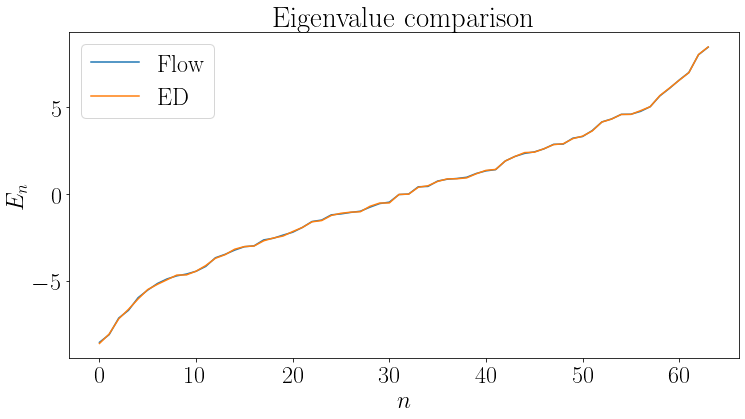

Relative error = 0.007255


In [15]:
flow = flow_levels(n,flow_list[-1])
ed = ED(n,H0,J,delta)
flow = flow-np.median(flow)
ed = ed-np.median(ed)

# Plot for comparison
plt.plot(flow,label=r'Flow')
plt.plot(ed,label=r'ED')
plt.legend()
plt.ylabel(r'$E_n$')
plt.xlabel(r'$n$')
plt.title(r'Eigenvalue comparison')
plt.show()
plt.close()

# Compute relative error
rel_err = np.mean([np.abs((flow[i]-ed[i])/ed[i]) for i in range(n)])
print('Relative error = %.6f' %rel_err)

The relative error is slightly larger than in the non-interacting case, which is to be expected as here we're dealing with an approximate solution to an interacting model. Nonetheless, for large $W$ and small $\Delta$ the relative error is still pretty small.

We can also compute various other things from the diagonal Hamiltonian, such as the interaction between the $l$-bits.

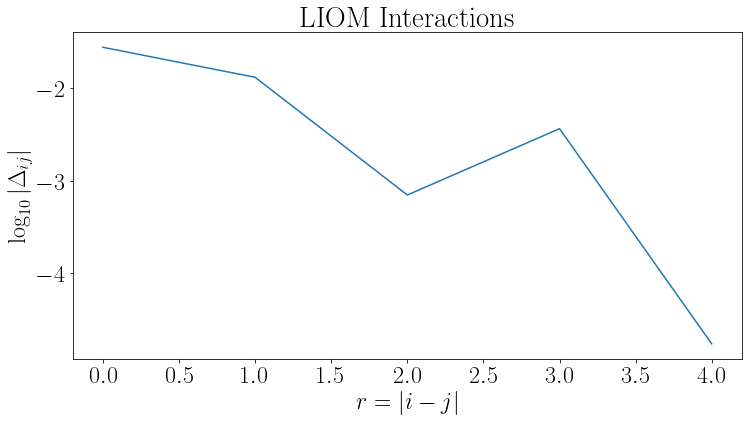

In [16]:
delta_mat = np.zeros((n,n))
HFint = flow_list[-1,n**2:].reshape(n,n,n,n)
for i in range(n):
    for j in range(n):
        delta_mat[i,j] += HFint[i,i,j,j]
        delta_mat[i,j] += -HFint[i,j,j,i]
delta_list = np.log10(np.abs([np.mean(np.diag(delta_mat,q)) for q in range(1,n)]))

plt.plot(delta_list)
plt.ylabel(r'$\log_{10}|\Delta_{ij}|$')
plt.xlabel(r'$r=|i-j|$')
plt.title(r'LIOM Interactions')
plt.show()
plt.close()

### Computing the LIOMs

Now we use the stored solution `flow_list` to compute the local integrals of motion (LIOMs).

The equation of motion (flow equation) for the LIOMs is the following:

$$
\frac{d \tilde{n}_i(l)}{d l} = [\eta(l),\tilde{n}_i(l)]
$$

and we want to integrate this *backwards* from the $l \to \infty$ diagonal basis back to the original $l=0$ initial microscopic basis. This will result in a LIOM of the following form:

$$
\tilde{n}_i = \sum_j \alpha^{(i)}_j n_j + \sum_{jk} \beta^{(i)}_{jk} c^{\dagger}_j c_k + \sum_{jk} \gamma^{(i)}_{jk} n_j n_k + \sum_{jkpq} \zeta^{(i)}_{jkpq} c^{\dagger}_j c_k c^{\dagger}_p c_q + ...
$$

where the tilde notation signifies operators in the diagonal basis, and the non-tilde notation refers to the microscopic basis. (So in other words, we're expressing a LIOM here as a superposition of microscopic fermions, which is exactly what we want.)

We already know $\eta(l)$ at each flow time step, so computing this is relatively easy. (Note: in this example we store $H(l)$, so at each flow time step we recalculate $\eta(l) = [H_0(l),V(l)]$, but in principle we can also store $\eta(l)$ directly and avoid this expensive step.)

The function to compute the RHS of this differential equation is basically the same as before, except now we pass the LIOM as the array named `y` and the Hamiltonian at a given flow time $H(l)$ as the array named `array`.

In [17]:
# Function to compute the RHS of the flow equation
def int_ode_liom(l,y,n,array):
    
    H2 = array[0:n**2].reshape(n,n)
    H4 = array[n**2:].reshape(n,n,n,n)
    
    n2 = y[0:n**2].reshape(n,n)
    n4 = y[n**2:].reshape(n,n,n,n)
    
    # Compute the generator from the Hamiltonian
    H0 = np.diag(np.diag(H2))
    V0 = H2 - H0
    eta2 = comm(H0,V0)
    
    Hint_diag = np.zeros((n,n,n,n)) # Define diagonal quartic part 
    for i in range(n):              # Load Hint_diag with values
        Hint_diag[i,i,i,i] = H4[i,i,i,i]
        for j in range(n):
            # Load Hint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
            Hint_diag[i,i,j,j] = H4[i,i,j,j]
            Hint_diag[i,j,j,i] = H4[i,j,j,i]
    Vint = (H4-Hint_diag)
    eta4 = comm(H0,Vint) + comm(Hint_diag,V0)
    
    # Now we compute the flow of the LIOM
    sol2 = comm(eta2,n2)
    sol4 = comm(eta2,n4) + comm(eta4,n2)
    
    sol = np.zeros(n**2+n**4)
    sol[0:n**2] = sol2.reshape(n**2)
    sol[n**2:] = sol4.reshape(n**4)

    return sol

We can set up and run the integrator almost exactly as before, paying particular attention to the fact that we're running the integration backwards so we have to reverse the order of `dl_list`. (Note: I don't reverse `sol_list` here and instead use the `sol_list[-k0]` notation because reversing the list creates a copy of it in the memory, and for large systems this doubles the memory cost so it's best to avoid it if possible. This is particularly true when running on a GPU, where memory is already limited.)

In [18]:
# Define integrator
r_int = ode(int_ode_liom).set_integrator('dopri5',nsteps=100)

# Numerically integrate the flow equations
k0 = 1                       # Flow timestep index
dl_list = dl_list[::-1]      # Reverse list of flow times

# Set initial conditions
init = np.zeros(n**2+n**4,dtype=np.float64)
init2 = np.zeros((n,n))
init2[n//2,n//2] = 1.0
init[:n**2] = init2.reshape(n**2)
r_int.set_initial_value(init,dl_list[0])
r_int.set_f_params(n)

# Integration continues until qmax is reached or all off-diagonal elements decay below cutoff
while r_int.successful() and k0 < k-1:
    r_int.set_f_params(n,flow_list[-k0])
    r_int.integrate(dl_list[k0])
    liom = r_int.y
    k0 += 1
print(k0)

475


Now that we've computed our $l$-bit, we can plot some parts of it. Here I'll show the real-space support of the quadratic part of the $l$-bit, and the real-space support of the quartic part. This is just to demonstrate how it looks - we'll look at a more interesting example in the next section.

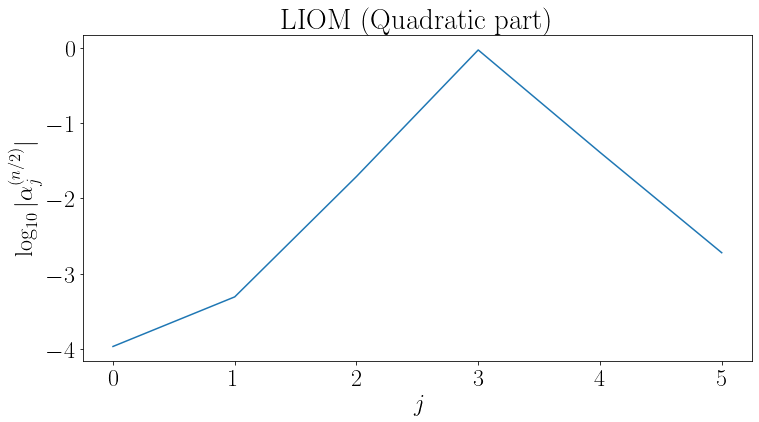

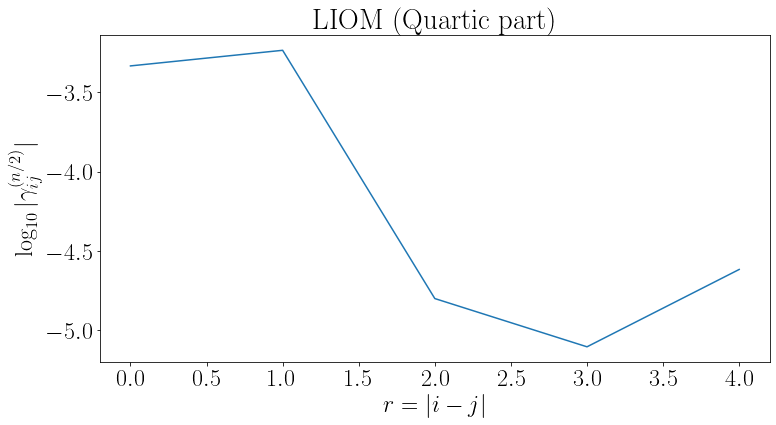

In [19]:
alpha_list = np.log10(np.abs(np.diag(liom[0:n**2].reshape(n,n))))

l4_list = np.zeros((n,n))
liom4 = liom[n**2:].reshape(n,n,n,n)
for i in range(n):
    for j in range(n):
        l4_list[i,j] += liom4[i,i,j,j]
        l4_list[i,j] += -liom4[i,j,j,i]
gamma_list = np.log10(np.abs([np.mean(np.diag(l4_list,q)) for q in range(1,n)]))


plt.plot(alpha_list)
plt.ylabel(r'$\log_{10}|\alpha^{(n/2)}_j|$')
plt.xlabel(r'$j$')
plt.title(r'LIOM (Quadratic part)')
plt.show()
plt.close()

plt.plot(gamma_list)
plt.ylabel(r'$\log_{10}|\gamma^{(n/2)}_{ij}|$')
plt.xlabel(r'$r=|i-j|$')
plt.title(r'LIOM (Quartic part)')
plt.show()
plt.close()

We can also compute the ratios $f_2$ and $f_4$ which are used to investigate the structure of the LIOMs, defined as the following:

$$
f_2 = \frac{1}{||n||}\left( \sum_j |\alpha^{(i)}_j|^2 + \sum_{jk} |\beta^{(i)}_{jk}|^2 \right)\\
f_4 = \frac{1}{||n||}\left(\sum_{jk} |\Gamma^{(i)}_{jk}|^2 + \sum_{jkpq} |\zeta^{(i)}_{jkpq}|^2 \right) \\
||n|| = \sum_j |\alpha^{(i)}_j|^2 + \sum_{jk} |\beta^{(i)}_{jk}|^2+\sum_{jk} |\Gamma^{(i)}_{jk}|^2 + \sum_{jkpq} |\zeta^{(i)}_{jkpq}|^2
$$

These can be computed as:

In [20]:
squared = np.sum([i**2 for i in liom])
f2 = np.sum([i**2 for i in liom[0:n**2]])
f4 = np.sum([i**2 for i in liom[n**2:]])
print('f_2 = %.16f' %f2)
print('f_4 = %.16f' %f4)

f_2 = 0.9999999999999999
f_4 = 0.0001383004180109


(Note: because of the way that the flow of the interacting terms is essentially decoupled from the non-interacting terms, up to machine precision $f_2$ will always be equal to one. The norm of the number operator is not conserved - more formally, it should be conserved only in the state used for normal-ordering, which is the vacuum state. And in any case, it's only conserved up to corrections of order $\Delta_0^2$ due to the truncation used here.)


## Putting the pieces together

I'll now define a function called `run` that combines all of the above steps in one. This function takes the system size, disorder strength, hopping amplitude and interaction strength as arguments. There is an optional keyword argument `dis=...` that can be used to specify the type of potential. In the following, we'll use `dis='linear'` to study Wannier-Stark localisation.

In [21]:
def run(n,W,J,delta,dis='random'):
    
    # Initialise the quadratic part of the Hamiltonian, as before

    if dis == 'random':
        H0 = np.diag(np.random.uniform(-W,W,n))
    elif dis == 'linear':
        H0 = np.diag(W*np.linspace(0,n-1,n))
    V = np.diag(J*np.ones(n-1),1)+np.diag(J*np.ones(n-1),-1)
    H = H0 + V

    # Initialise the interacting (quartic) part of the Hamiltonian

    Hint = np.zeros((n,n,n,n))
    for i in range(1,n):
        for j in range(1,n):
            if abs(i-j)==1:
                Hint[i,i,j,j] = 0.5*delta
        
    # Generate list of flow time steps to store
    dl_list = np.logspace(-2,3,500,endpoint = True)

    # Initialise array to hold solution at all flow times
    flow_list = np.zeros((len(dl_list),n**2+n**4))

    # Define integrator
    r_int = ode(int_ode).set_integrator('dopri5',nsteps=100)

    # Set initial conditions
    init = np.zeros(n**2+n**4,dtype=np.float64)
    init[:n**2] = ((H)).reshape(n**2)
    init[n**2:] = (Hint).reshape(n**4)
    r_int.set_initial_value(init,dl_list[0])
    r_int.set_f_params(n)
    flow_list[0] = init

    # Numerically integrate the flow equations
    k = 1                       # Flow timestep index
    J0 = 10.                    # Seed value for largest off-diagonal term
    # Integration continues until qmax is reached or all off-diagonal elements decay below cutoff
    while r_int.successful() and k < len(dl_list):
        r_int.integrate(dl_list[k])
        step = r_int.y
        flow_list[k] = step
        k += 1
    flow_list = flow_list[0:k-1]
    dl_list = dl_list[0:k-1]
    
    delta_mat = np.zeros((n,n))
    HFint = flow_list[-1,n**2:].reshape(n,n,n,n)
    for i in range(n):
        delta_mat[i,i] = HFint[i,i,i,i]
        for j in range(n):
            if i != j:
                delta_mat[i,j] += HFint[i,i,j,j]
                delta_mat[i,j] += -HFint[i,j,j,i]
    delta_list = np.log10(np.abs([np.mean(np.diag(delta_mat,q)) for q in range(1,n)]))
    
    flow = flow_levels(n,flow_list[-1])
    ed = ED(n,H0,J,delta)
    flow = flow-np.median(flow)
    ed = ed-np.median(ed)

    # Compute relative error
    rel_err = np.mean([np.abs((flow[i]-ed[i])/ed[i]) for i in range(n)])
    
    # Define integrator
    r_int = ode(int_ode_liom).set_integrator('dopri5',nsteps=100)

    # Numerically integrate the flow equations
    k0 = 1                       # Flow timestep index
    dl_list = dl_list[::-1]      # Reverse list of flow times
    
    # Set initial conditions
    init = np.zeros(n**2+n**4,dtype=np.float64)
    init2 = np.zeros((n,n))
    init2[n//2,n//2] = 1.0
    init[:n**2] = init2.reshape(n**2)
    r_int.set_initial_value(init,dl_list[0])
    r_int.set_f_params(n)

    # Integration continues until qmax is reached or all off-diagonal elements decay below cutoff
    while r_int.successful() and k0 < k-1:
        r_int.set_f_params(n,flow_list[-k0])
        r_int.integrate(dl_list[k0])
        liom = r_int.y
        k0 += 1
    
    alpha_list = np.log10(np.abs(np.diag(liom[0:n**2].reshape(n,n))))

    l4_list = np.zeros((n,n))
    liom4 = liom[n**2:].reshape(n,n,n,n)
    for i in range(n):
        for j in range(n):
            l4_list[i,j] += liom4[i,i,j,j]
            l4_list[i,j] += -liom4[i,j,j,i]
    gamma_list = np.log10(np.abs([np.mean(np.diag(l4_list,q)) for q in range(1,n)]))
    
    squared = np.sum([i**2 for i in liom])
    f2 = np.sum([i**2 for i in liom[0:n**2]])/squared
    f4 = np.sum([i**2 for i in liom[n**2:]])/squared
    
    output = {"Hfinal":flow_list[-1],"Delta_list":delta_list,"Alpha_list":alpha_list,"Gamma_list":gamma_list,"err":rel_err,"f2":f2,"f4":f4}
    
    return output

I'll also take this opportunity to rewrite the matrix/tensor contraction function to use some custom generalised universal functions (gufuncs) making use of numba's `guvectorize` decorator, which on my system I find a lot faster than NumPy's `einsum` or `tensordot` functions. (Numba's `jit` decorator is good too for large systems, but for moderate values of `n` I find `guvectorize` almost always outperforms it.)

In [22]:
from numba import guvectorize,float64

@guvectorize([(float64[:,:],float64[:,:],float64[:,:])],'(n,n),(n,n)->(n,n)',target='cpu',nopython=True)
def con_vec(A,B,C):
    m,_=A.shape
    for i in range(m):
        for j in range(m):
            for k in range(m):
                C[i,j] += A[i,k]*B[k,j] - B[i,k]*A[k,j]
            
@guvectorize([(float64[:,:,:,:],float64[:,:],float64[:,:,:,:])],'(n,n,n,n),(n,n)->(n,n,n,n)',target='cpu',nopython=True)
def con_vec42(A,B,C):
    m,_,_,_=A.shape
    for i in range(m):
        for j in range(m):
            for k in range(m):
                for q in range(m):
                    for l in range(m):
                        C[i,j,k,q] += A[i,j,k,l]*B[l,q] 
                        C[i,j,k,q] += -A[i,j,l,q]*B[k,l]
                        C[i,j,k,q] += A[i,l,k,q]*B[l,j]
                        C[i,j,k,q] += -A[l,j,k,q]*B[i,l] 
                        
def comm(A,B):
    if A.ndim == B.ndim:
        if A.ndim ==2:
            con = np.zeros((n,n))
            con_vec(A,B,con)
        else:
            print('High order terms not implemented in this version!')
    
    elif A.ndim==4 and B.ndim==2:
        con = np.zeros(A.shape)
        con_vec42(A,B,con)
        
    elif A.ndim==2 and B.ndim==4:
        con = np.zeros(B.shape)
        con_vec42(B,A,con)
        con *= -1
        
    return con

A few technical remarks on the above code: you can also use `target='cuda'` or `target='parallel'` to change the compile target, but in for small systems the best choice seems to be `cpu`, and I've never found a situation where `cuda` was useful, as there is quite a lot of overhead incurred by creating the arrays on the CPU and then moving them to and from the GPU in order to compute the contractions. For running on a GPU, it's better to rewrite all of the above in JAX or PyTorch. (Note that neither are as straightforward as SciPy, and both require workarounds to get them running properly - PyTorch won't accept ragged lists of different sizes, and JAX won't allow the passing of time-dependent arguments into the ODE functions.)

We can now use this to study the LIOMs and their interactions for a variety of disorder strengths and plot the results. Here I show the LIOM interactions $\Delta_{ij}$ versus distance, and the real-space support of the quadratic part of the LIOM, overlaid with the exact analytical result for the non-interacting system (black Xs).

These are included as toy calculations - feel free to modify, test out new things and try to break them!

Time taken:  0:00:09.122191
Time taken:  0:00:08.759381
Time taken:  0:00:08.695787
Time taken:  0:00:08.620995


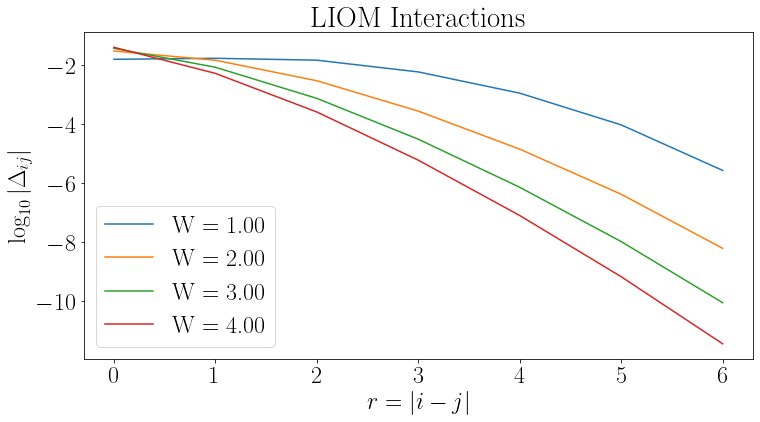

Time taken:  0:00:09.153426
Time taken:  0:00:08.853675
Time taken:  0:00:08.845931
Time taken:  0:00:08.750731


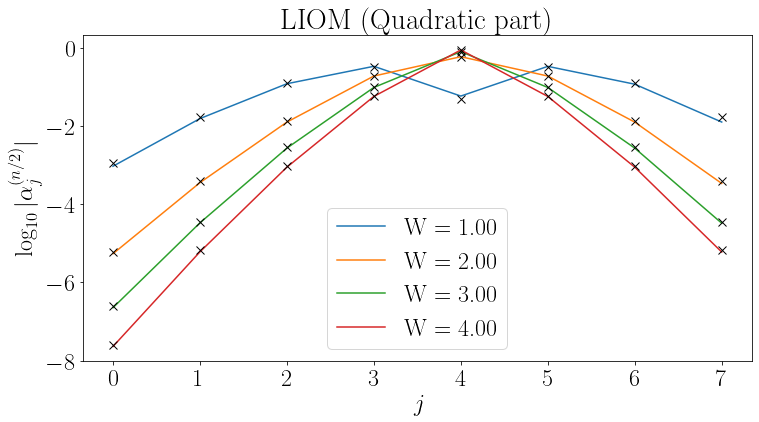

In [27]:
n = 8
J = 1.0
delta = 0.1
from datetime import datetime

# SciPy often throws dopri5 step-size errors when the flow terminates early, so this switches them off
# Again, test with the errors turned on and only turn off when running 'proper' code
import warnings
warnings.filterwarnings("ignore")

for W in range(1,5):
    startTime = datetime.now()
    flow = run(n,W,J,delta,'linear')
    print('Time taken: ', datetime.now()-startTime)
    plt.plot(flow["Delta_list"],label='W = %.2f' %W)
plt.ylabel(r'$\log_{10}|\Delta_{ij}|$')
plt.xlabel(r'$r=|i-j|$')
plt.title(r'LIOM Interactions')
plt.legend()
plt.show()
plt.close()

from scipy.special import jv as jv
# This is a bit of a waste of effort to compute the flow twice, but I'm writing this notebook in a hurry...
for W in range(1,5):
    startTime = datetime.now()
    flow = run(n,W,J,delta,'linear')
    print('Time taken: ', datetime.now()-startTime)
    plt.plot(flow["Alpha_list"],label='W = %.2f' %W)
    
    bessel = np.zeros(n)
    for i in range(n):
        bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/W)**2))
    plt.plot(bessel,'kx',markersize='8')

plt.ylabel(r'$\log_{10}|\alpha^{(n/2)}_j|$')
plt.xlabel(r'$j$')
plt.title(r'LIOM (Quadratic part)')
plt.legend()
plt.show()
plt.close()

Here I demonstrate the relative error versus the gradient of the linear slope. Be warned though - the calculation of the relative error does not take into account any off-diagonal elements of the Hamiltonian that have not decayed, as it assumes they are all zero. This can give an error that is unrealistically small even in regimes where the Hamiltonian diverges, so be sure to check that the Hamiltonian has converged before trusting this measure. (Here, for example, the Hamiltonian probably has not converged for values $W<1$.)

Time taken:  0:00:09.811235
Time taken:  0:00:09.788486
Time taken:  0:00:09.812684
Time taken:  0:00:09.571121
Time taken:  0:00:09.307517
Time taken:  0:00:09.321821
Time taken:  0:00:09.258113
Time taken:  0:00:09.253484
Time taken:  0:00:09.218109
Time taken:  0:00:09.164278
Time taken:  0:00:09.130882


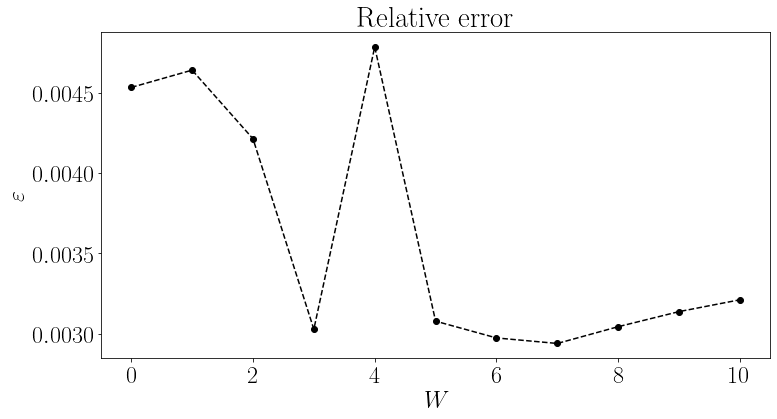

In [24]:
n=8
dlist = [0.7+0.05*i for i in range(11)]
errlist = np.zeros(len(dlist))

dcount = 0
for W in dlist:
    startTime = datetime.now()
    flow = run(n,W,J,delta,'linear')
    print('Time taken: ', datetime.now()-startTime)
    errlist[dcount] = flow["err"]
    dcount += 1
    
plt.plot(errlist,'ko--')
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$W$')
plt.title(r'Relative error')
plt.show()
plt.close()

We can also use the `run` function to construct the $f_2$ and $f_4$ plots that we use to estimate the location of the phase transition. (This will take a little longer due to the number of points and the different system sizes - darker colours represent larger systems.)

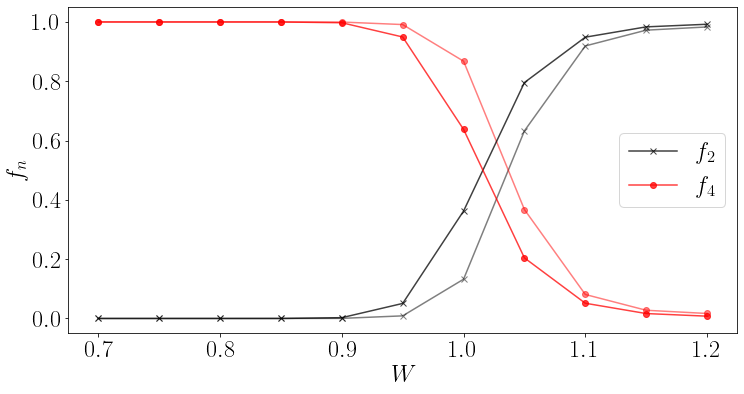

In [25]:
dlist = [0.7+0.05*i for i in range(11)]
delta = 0.1

for n in [8,12]:
    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))

    dcount = 0
    for W in dlist:
        startTime = datetime.now()
        flow = run(n,W,J,delta,'linear')
#         print(W,flow["err"])
#         print('Time taken: ', datetime.now()-startTime)
        f2list[dcount] = flow["f2"]
        f4list[dcount] = flow["f4"]

        dcount += 1

    if n == 12:
        plt.plot(dlist,f2list,'kx-',label=r'$f_2$',alpha=n/16)
        plt.plot(dlist,f4list,'ro-',label=r'$f_4$',alpha=n/16)
    else:
        plt.plot(dlist,f2list,'kx-',alpha=n/16)
        plt.plot(dlist,f4list,'ro-',alpha=n/16)
        
plt.ylabel(r'$f_n$')
plt.xlabel(r'$W$')
plt.legend()
plt.show()
plt.close()